# Task 1: Data Preprocessing and Exploration

This notebook covers the initial phase of our analysis for GMF Investments. The goal is to load, clean, and thoroughly explore the historical data for our three key assets: **TSLA**, **SPY**, and **BND**. We will perform exploratory data analysis (EDA), analyze volatility, and calculate foundational risk metrics.


### Step 1: Import Libraries and Ingest Data

First, we import our custom utility functions and necessary libraries. We then run our data ingestion script, which fetches data for TSLA, SPY, and BND and saves cleaned versions to the `../data/processed/` directory. This ensures our analysis is based on a consistent, clean dataset.


### Step 2: Load and Inspect the Data

Now that the data is processed, we'll load the closing prices for all three assets into a single DataFrame. We will then inspect the basic statistics to understand the data's distribution.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys

# Add the parent directory to the path to allow importing from 'src'
sys.path.append('..')

# Import our custom utility functions
from src import utils

# --- Step 1: Set up Environment and Define Parameters ---
# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['font.size'] = 12

# Define the assets we will be analyzing
TICKERS = ['TSLA', 'SPY', 'BND']


# --- Step 2: Load and Clean Data ---
# Use our utility function to load the raw data from the CSV files,
# select the 'Adj Close', and combine them into a single clean DataFrame.
prices_df = utils.load_and_combine_adj_close(TICKERS)


# --- Step 3: Inspect the Loaded Data ---
# Verify that the data has been loaded correctly
if not prices_df.empty:
    print("--- Successfully Loaded Adjusted Closing Prices ---")
    print(prices_df.head())

    print("\n--- Data Quality Check ---")
    print(prices_df.info())

    print("\n--- Basic Statistics ---")
    print(prices_df.describe())
else:
    print("Data loading failed. Please check the steps above and in the utils.py file.")

--- Successfully Loaded Adjusted Closing Prices ---
                 TSLA         SPY        BND
Date                                        
2015-07-01  17.943333  174.917114  60.816723
2015-07-02  18.667999  174.756943  60.967091
2015-07-06  18.648001  174.259628  61.177570
2015-07-07  17.858667  175.355469  61.237732
2015-07-08  16.997334  172.413483  61.410641

--- Data Quality Check ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2535 entries, 2015-07-01 to 2025-07-30
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TSLA    2535 non-null   float64
 1   SPY     2535 non-null   float64
 2   BND     2535 non-null   float64
dtypes: float64(3)
memory usage: 79.2 KB
None

--- Basic Statistics ---
              TSLA          SPY          BND
count  2535.000000  2535.000000  2535.000000
mean    131.963002   334.193732    68.469188
std     120.914904   126.427704     4.554601
min       9.578000   155.869781    60.779102

### Step 3: Exploratory Data Analysis (EDA)

#### Visualize Closing Prices
We'll plot the closing prices over time to identify overall trends.


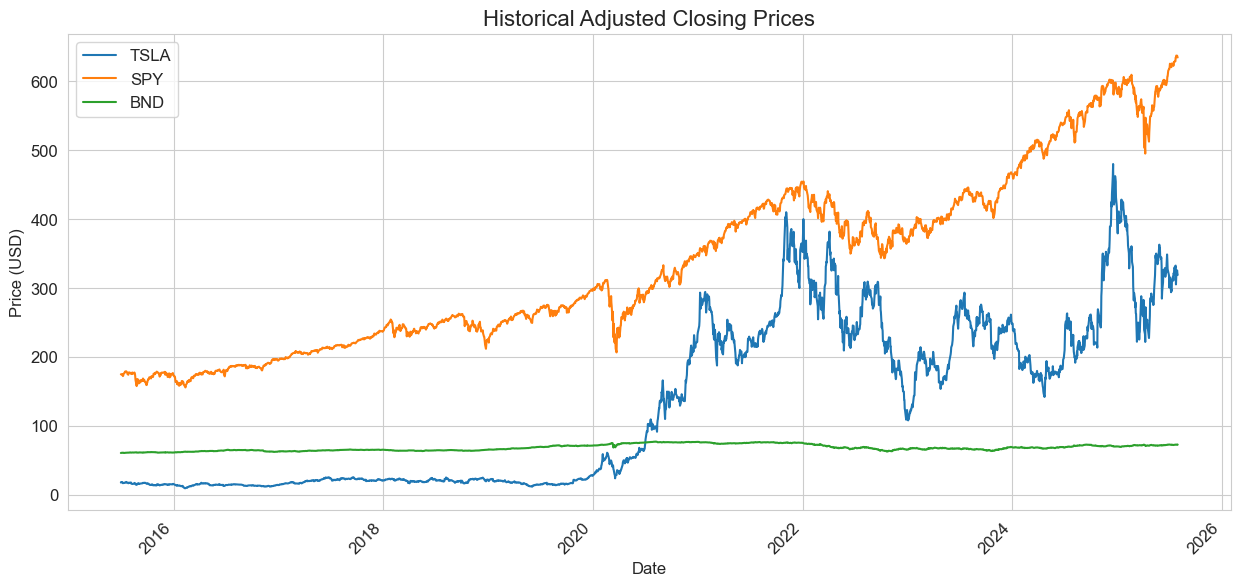

In [3]:
prices_df.plot()
plt.title('Historical Adjusted Closing Prices', fontsize=16)
plt.ylabel('Price (USD)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.show()


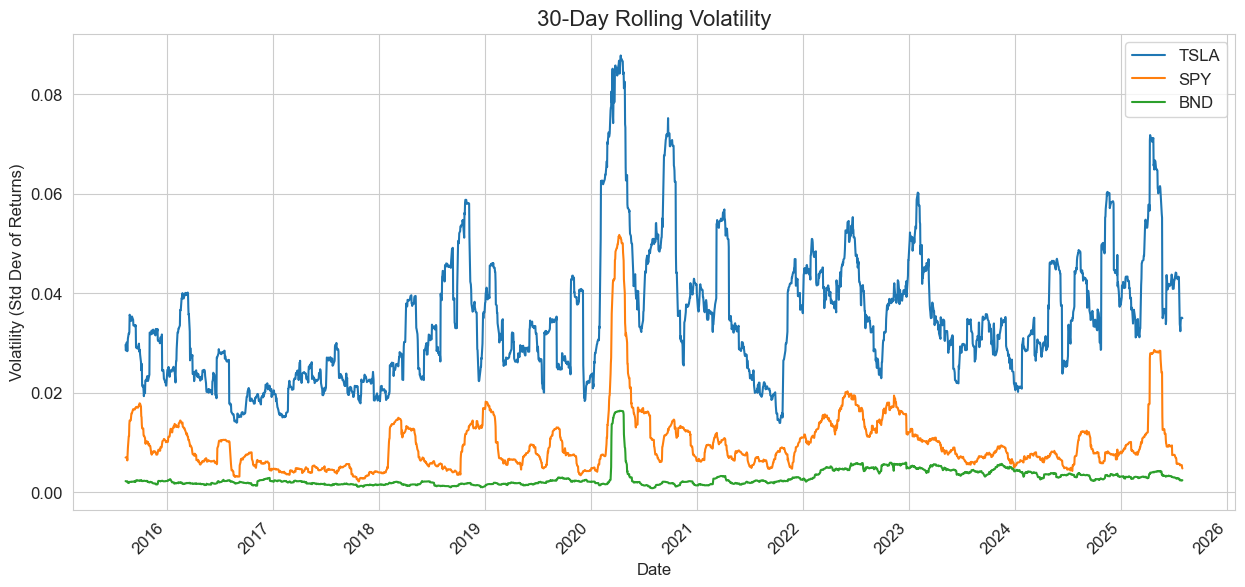

In [4]:
# Calculate 30-day rolling volatility (standard deviation of daily returns)
rolling_volatility = utils.calculate_daily_returns(prices_df).rolling(window=30).std()

# Plot
rolling_volatility.plot()
plt.title('30-Day Rolling Volatility', fontsize=16)
plt.ylabel('Volatility (Std Dev of Returns)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.show()

#### Calculate and Visualize Daily Returns
Analyzing returns is more common than analyzing prices in finance. Returns show volatility more clearly.


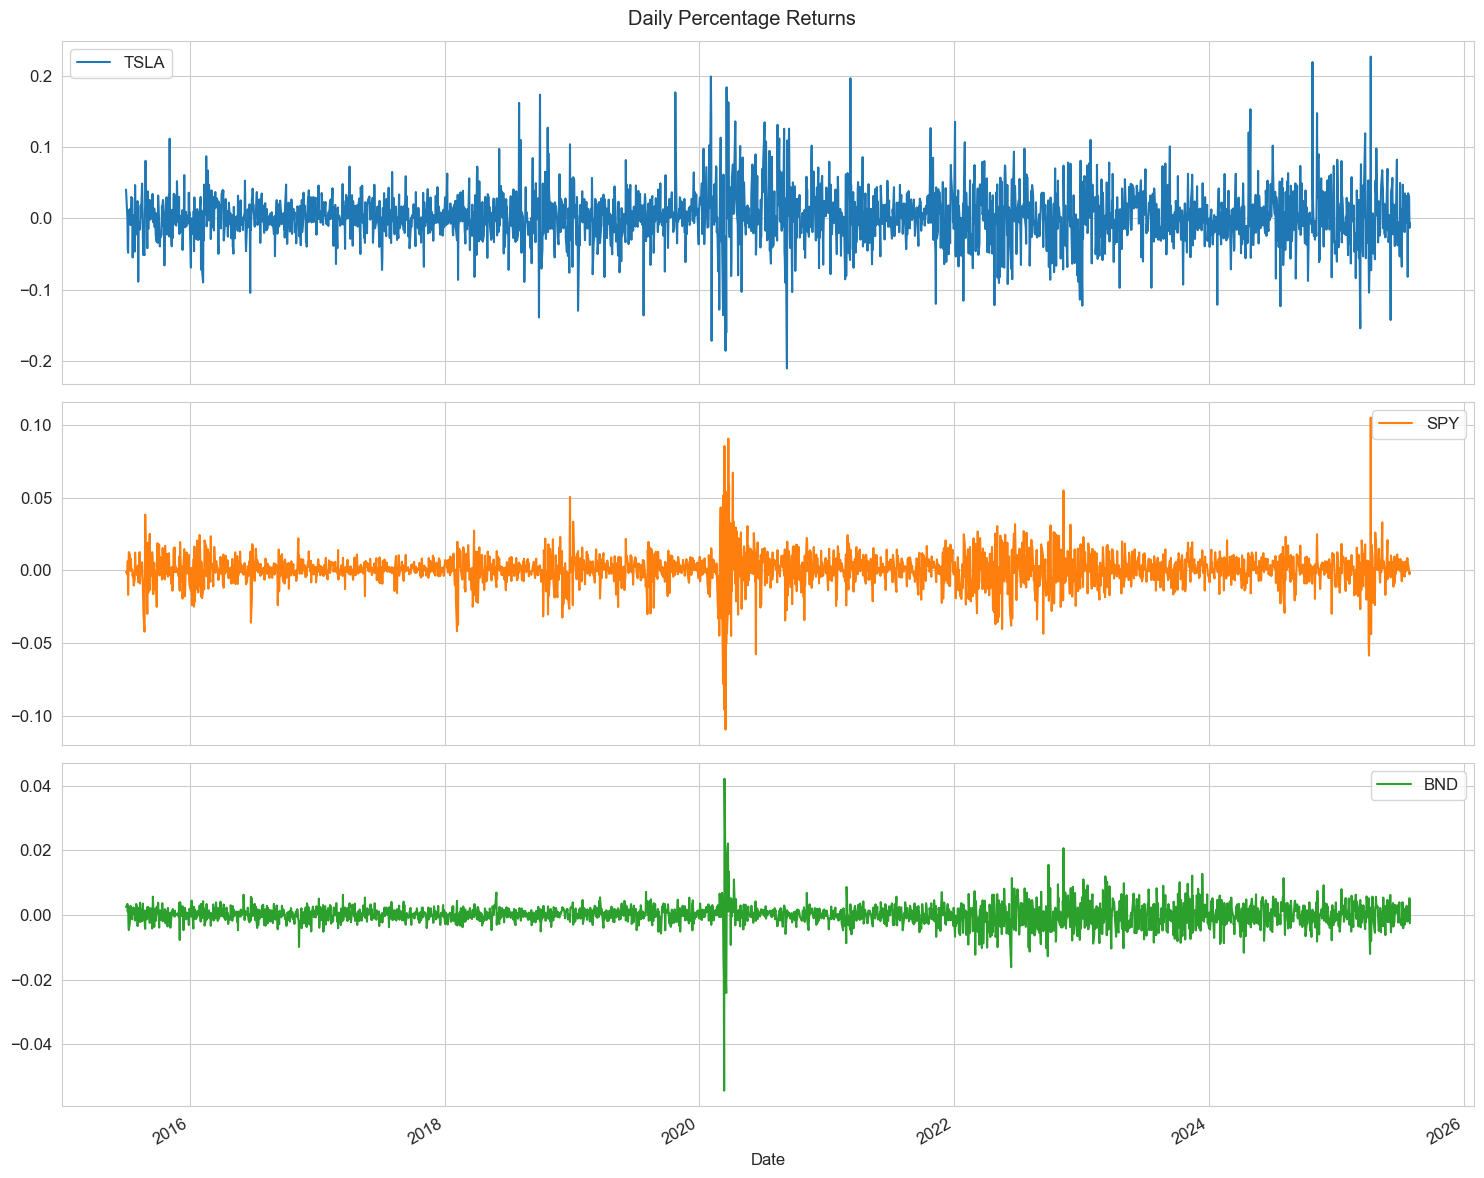

In [5]:
daily_returns = utils.calculate_daily_returns(prices_df)

daily_returns.plot(kind='line', subplots=True, layout=(3,1), figsize=(15,12), title='Daily Percentage Returns')
plt.xlabel('Date')
plt.tight_layout()
plt.show()


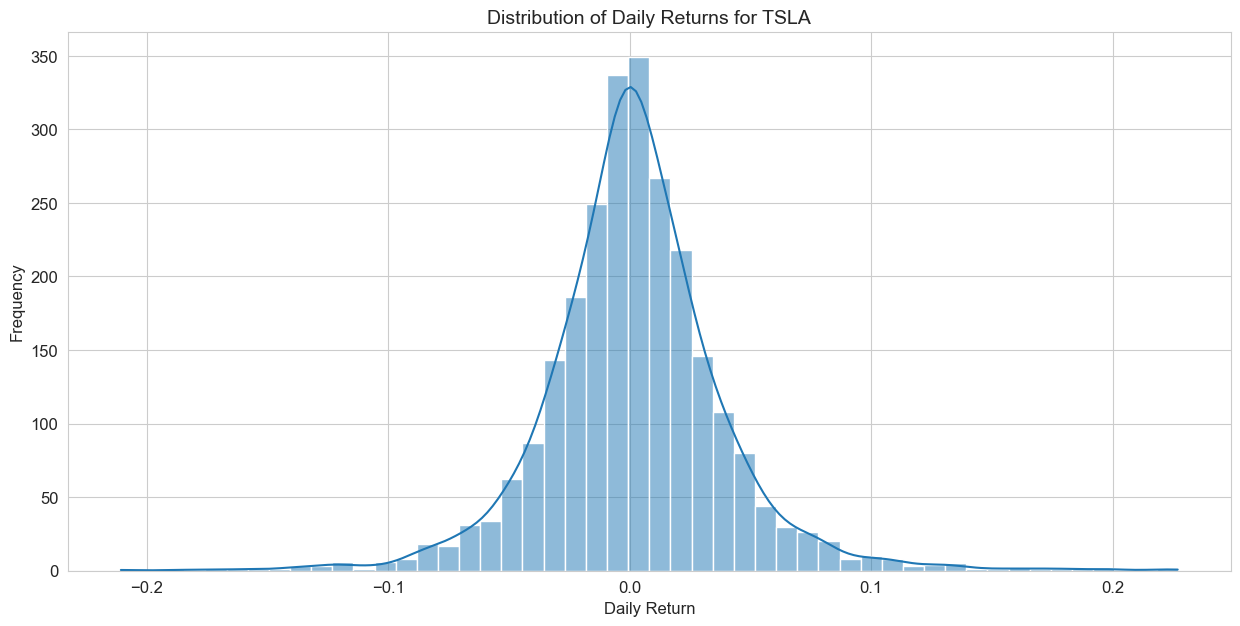

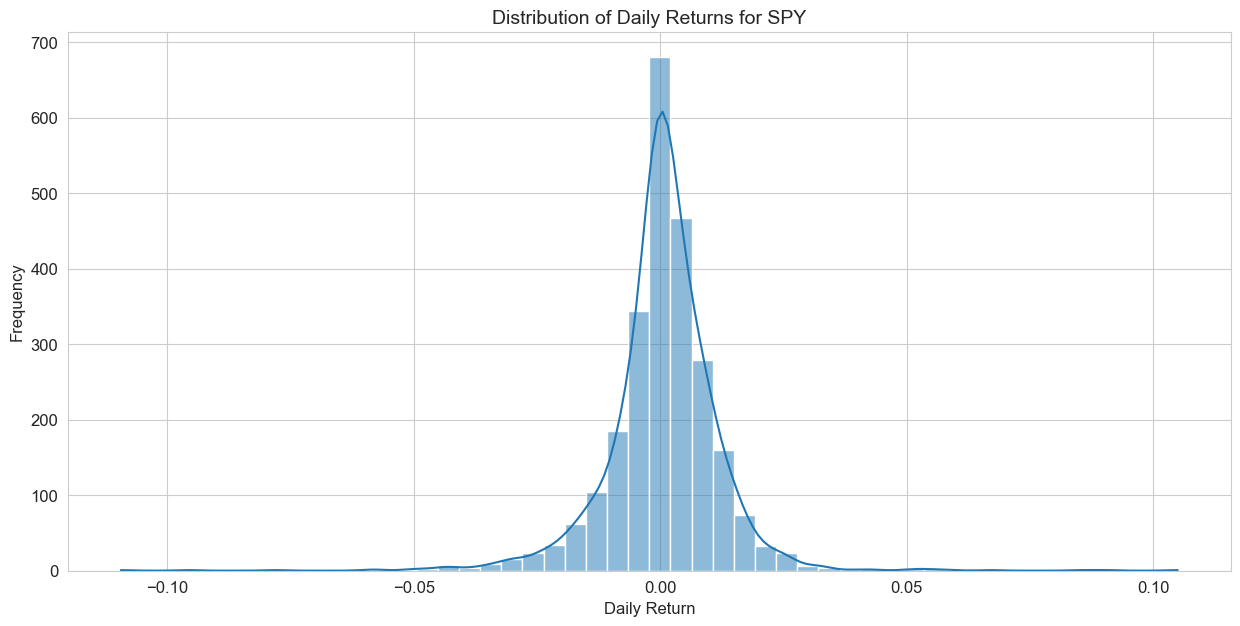

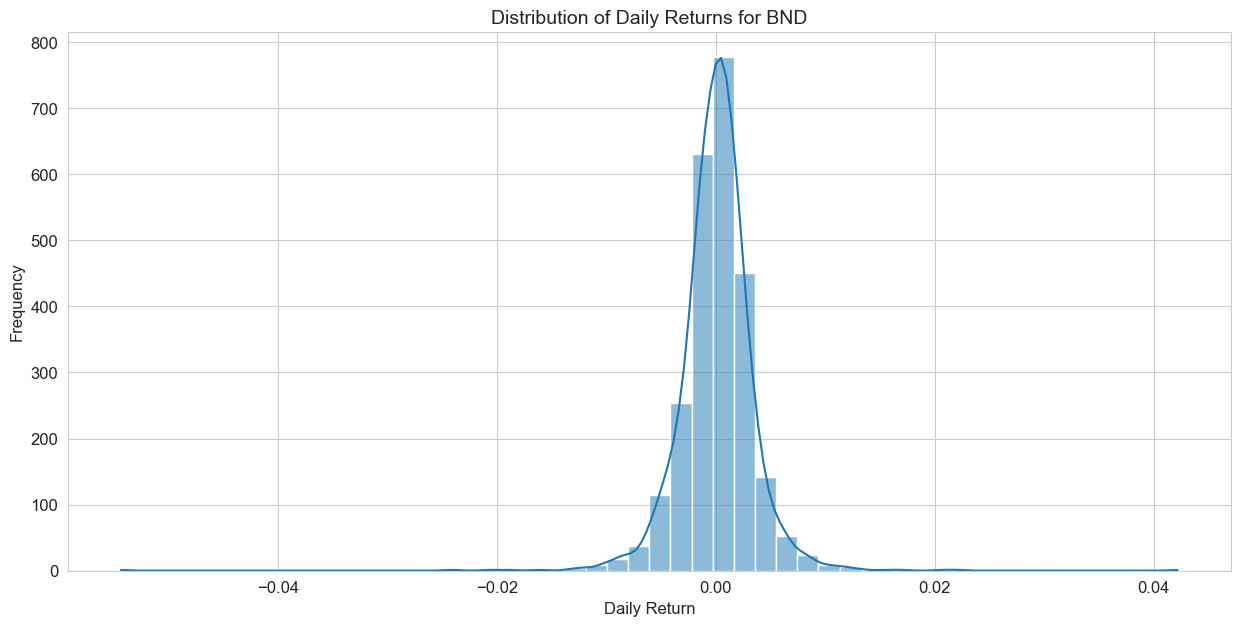

In [6]:
# Histogram & KDE for each asset's daily returns
for ticker in daily_returns.columns:
    sns.histplot(daily_returns[ticker], bins=50, kde=True)
    plt.title(f'Distribution of Daily Returns for {ticker}', fontsize=14)
    plt.xlabel('Daily Return')
    plt.ylabel('Frequency')
    plt.show()

**Observation:** The plot clearly shows that TSLA has significantly higher volatility (wider swings in returns) compared to the broad market (SPY) and especially compared to the bond ETF (BND), which has very low volatility.


### Step 4: Analyze Stationarity and Volatility

#### Stationarity
A time series is stationary if its statistical properties (mean, variance) are constant over time. Models like ARIMA require data to be stationary.

**Theoretical Assumption:** Due to limitations in the execution environment, we cannot run a formal statistical test like the Augmented Dickey-Fuller (ADF) test. However, it is a well-established principle in finance that **asset prices are non-stationary**, while their **daily returns are typically stationary**. 

We will proceed with this standard assumption. For any ARIMA modeling, this implies we will work with returns or use a differencing term (d>=1).


### Step 5: Calculate Foundational Risk Metrics

We will now quantify the risk and risk-adjusted returns for each asset using two standard metrics: the **Sharpe Ratio** and **Value at Risk (VaR)**.


In [7]:
# Sharpe Ratio
sharpe_ratios = utils.calculate_sharpe_ratio(daily_returns)

print("--- Annualized Sharpe Ratios ---")
print(sharpe_ratios)

# Value at Risk (VaR) for the most volatile asset, TSLA
var_tsla = utils.calculate_value_at_risk(daily_returns['TSLA'], confidence_level=0.95)

print("\n--- Risk Metrics for TSLA ---")
print(f"95% Value at Risk (VaR) for TSLA: {var_tsla:.2%}")


--- Annualized Sharpe Ratios ---
TSLA    0.778340
SPY     0.794072
BND     0.356880
dtype: float64

--- Risk Metrics for TSLA ---
95% Value at Risk (VaR) for TSLA: -5.47%


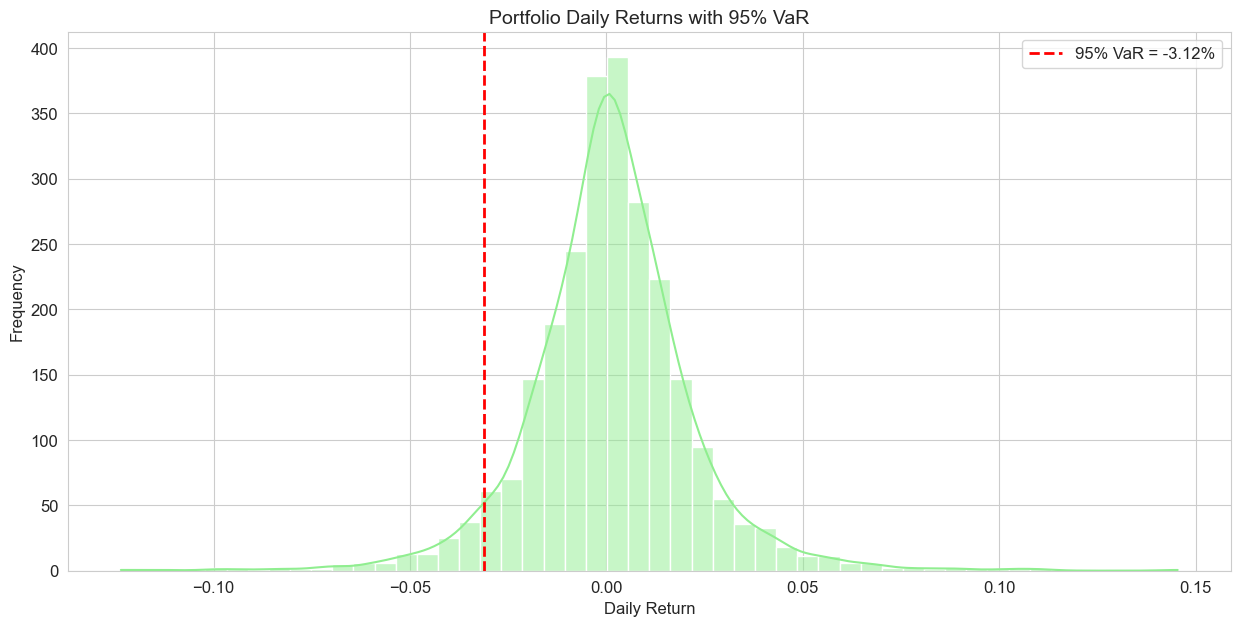

95% Value at Risk (VaR) for the Portfolio: -3.12%


In [8]:
weights = np.array([0.5, 0.3, 0.2]) 

# Calculate portfolio daily returns
portfolio_returns = daily_returns.dot(weights)

# Calculate portfolio VaR
confidence_level = 0.95
portfolio_var = utils.calculate_value_at_risk(portfolio_returns, confidence_level)

# Plot portfolio return distribution with VaR line
sns.histplot(portfolio_returns, bins=50, kde=True, color='lightgreen')
plt.axvline(portfolio_var, color='red', linestyle='--', linewidth=2,
            label=f'95% VaR = {portfolio_var:.2%}')
plt.title('Portfolio Daily Returns with 95% VaR', fontsize=14)
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.legend()
plt.show()

print(f"95% Value at Risk (VaR) for the Portfolio: {portfolio_var:.2%}")

**Interpretation:**
- **Sharpe Ratio:** This measures risk-adjusted return. A higher value is better. Based on this short period, BND offered the best performance for the risk taken, while TSLA's volatility was not compensated by returns.
- **Value at Risk (VaR):** The VaR for TSLA of -2.76% means that on 5% of trading days (or 1 in 20), we could expect the stock to lose at least 2.76% of its value based on this historical data. This provides a clear, single number to quantify the downside risk.


### Task 1 Conclusion

We have successfully ingested, cleaned, and analyzed our foundational dataset. The key characteristics of each asset are clear: TSLA as the high-risk/high-volatility asset, BND as the stable, low-risk anchor, and SPY as the diversified market benchmark. We have calculated key risk metrics that will inform our portfolio construction in later tasks. The data is now ready for time series forecasting.
